# Imports

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from string import ascii_lowercase, digits
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from os import listdir
from os.path import join
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchmetrics import CharErrorRate
from torchinfo import summary

# Lets fix random seed

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3060 Laptop GPU


# Constants

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VAL_SIZE = 0.1
BATCH_SIZE = 64
CAPTCHA_SIZE = 5
EPOCHS = 100
DATASET_PATH = 'samples'
EXT = '.png'
BLANK = '.'

# Dataset

In [4]:
unique_chars = [BLANK] + sorted(set(''.join(name.split('.')[0] for name in listdir(DATASET_PATH) if EXT in name)))
VOCAB_SIZE = len(unique_chars)
print(VOCAB_SIZE, unique_chars)
id_to_ch = dict(enumerate(unique_chars))
ch_to_id = {ch: i for i, ch in id_to_ch.items()}

20 ['.', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [5]:
encoder = LabelEncoder()
encoder.fit(unique_chars)

LabelEncoder()

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset_path: str, label_encoding: dict):
        self.dir = dataset_path
        self.images = listdir(self.dir)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        self.label_encoding = label_encoding

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int):
        image_path = self.images[index]
        with Image.open(join(self.dir, image_path)).convert('RGB') as img:
            img.load()
        y = image_path.split(".")[0]
        label = torch.from_numpy(self.label_encoding.transform(list(y))).type(torch.long)

        return self.transform(img), label

In [7]:
def get_train_val_loaders(dataset_path: str):
    dataset = CustomDataset(dataset_path, label_encoding=encoder)
    N = len(dataset.images)
    val_size = int(N * VAL_SIZE)
    train_dataset, val_dataset = random_split(dataset, [N - val_size, val_size])
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    return train_loader, val_loader

train_loader, val_loader = get_train_val_loaders(DATASET_PATH)

# Model

In [8]:
class Model(torch.nn.Module):
    def __init__(self, dim, dim_out):
        super(Model, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, dim, 5, stride=2, padding=2),
            nn.BatchNorm2d(dim),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(dim, dim*2, 3, padding=1),
            nn.BatchNorm2d(dim*2),
            nn.Dropout(0.1),
            nn.Conv2d(dim*2, dim*4, 3, padding=1),
            nn.BatchNorm2d(dim*4),
            nn.Dropout(0.1),
            nn.Conv2d(dim*4, dim*8, 3, padding=1)
        )
        self.fc1 = nn.Linear(dim*8*13, dim*4)
        self.rnn = nn.LSTM(dim*4, dim*2, 2, bidirectional=True, batch_first=True)
        self.fc2 = nn.Linear(dim*2*2, dim_out)
        self.pool = nn.AdaptiveAvgPool1d(CAPTCHA_SIZE)

    def forward(self, x):
        bs, _, _, _ = x.size()
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x, _ = self.rnn(x)
        x = self.fc2(x).transpose(1, 2)
        x = self.pool(x)

        return x

In [9]:
model = Model(dim=64, dim_out=VOCAB_SIZE)
model.to(DEVICE)
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       4,864
│    └─BatchNorm2d: 2-2                  128
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       73,856
│    └─BatchNorm2d: 2-5                  256
│    └─Dropout: 2-6                      --
│    └─Conv2d: 2-7                       295,168
│    └─BatchNorm2d: 2-8                  512
│    └─Dropout: 2-9                      --
│    └─Conv2d: 2-10                      1,180,160
├─Linear: 1-2                            1,704,192
├─LSTM: 1-3                              790,528
├─Linear: 1-4                            5,140
├─AdaptiveAvgPool1d: 1-5                 --
Total params: 4,054,804
Trainable params: 4,054,804
Non-trainable params: 0

# Training

In [10]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = Adam(model.parameters())

In [11]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50):
    train_losses, val_losses = [], []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = val_loss = .0
        for X, y in tqdm(train_loader, leave=False):
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            for X, y in tqdm(val_loader, leave=False):
                X = X.to(DEVICE)
                y = y.to(DEVICE)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, train loss: {train_loss:.4f},  val. loss: {val_loss:.4f}")

    return train_losses, val_losses

In [12]:
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10, train loss: 1.8151,  val. loss: 2.7014


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20, train loss: 1.2266,  val. loss: 2.6692


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 30, train loss: 0.5380,  val. loss: 1.0270


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 40, train loss: 0.5480,  val. loss: 1.5729


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 50, train loss: 0.7280,  val. loss: 1.6863


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 60, train loss: 0.8295,  val. loss: 1.7036


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 70, train loss: 0.3477,  val. loss: 0.9344


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 80, train loss: 0.0643,  val. loss: 0.4895


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 90, train loss: 0.0289,  val. loss: 0.3364


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 100, train loss: 0.0144,  val. loss: 0.3841


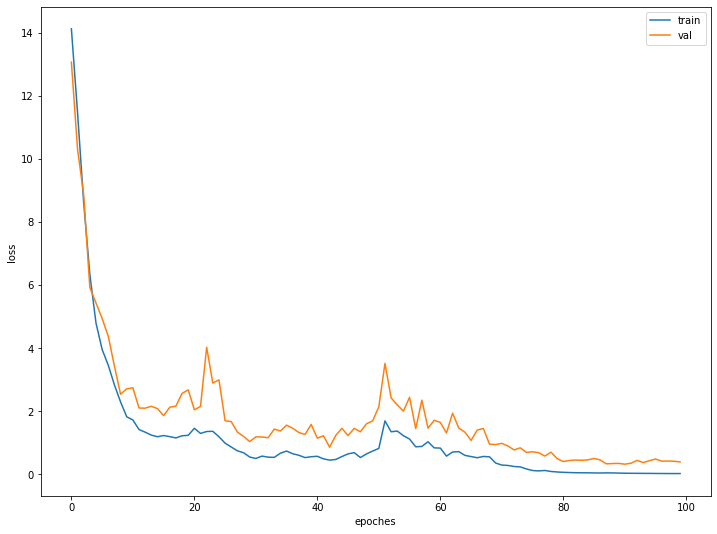

In [13]:
plt.figure(figsize=(12, 9))
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.xlabel('epoches')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluating

In [14]:
def evaluate(model, data_loader, encoder, k=10):
    model.eval()
    metric = CharErrorRate()
    predictions = []
    targets = []
    cers = []
    
    with torch.no_grad():
        for X, y in tqdm(data_loader):
            X = X.to(DEVICE)
            outputs = model(X).cpu().argmax(1)
            predictions.extend(''.join(encoder.inverse_transform(prediction)) for prediction in outputs)
            targets.extend(''.join(encoder.inverse_transform(target)) for target in y)

    cers = [metric(pred, target) for pred,target in zip(predictions, targets)]
    cer = CharErrorRate()(predictions, targets).item()
    wrong_predictions = np.argsort(cers)[-k:]

    for ids in wrong_predictions:
        plt.figure()
        plt.title(f"Prediction: {predictions[ids]}\nLabel: {targets[ids]}\nCER: {cers[ids]:.2f}")
        plt.imshow(data_loader.dataset[ids][0].permute(1, 2, 0) / 2 + .5)    

    return cer

  0%|          | 0/16 [00:00<?, ?it/s]

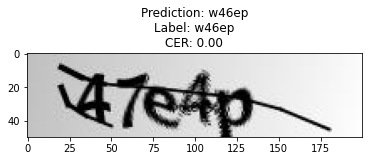

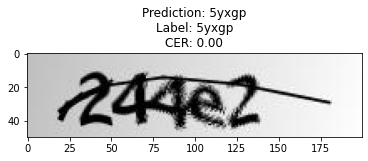

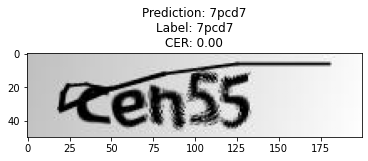

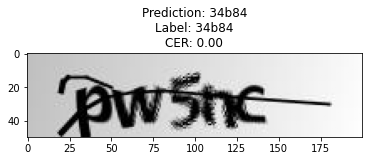

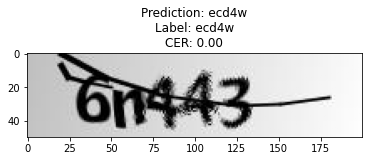

In [15]:
train_cer = evaluate(model, train_loader, encoder, k=5)
# Below images doesn't correspond to label due to `shuffle=True` in train_loader

  0%|          | 0/2 [00:00<?, ?it/s]

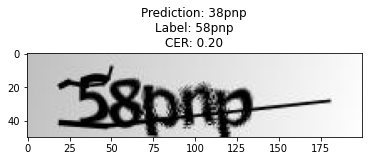

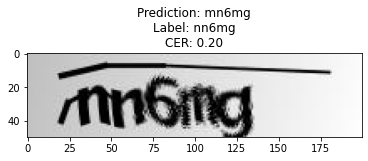

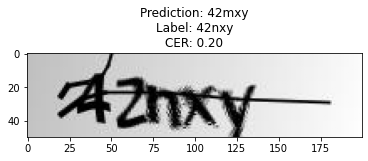

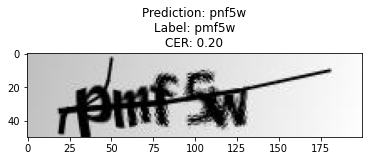

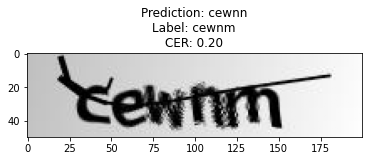

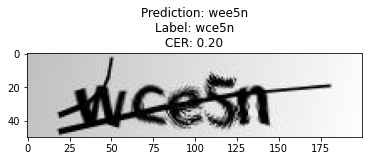

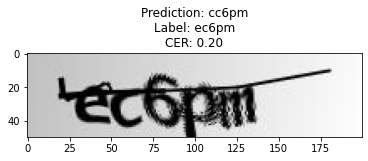

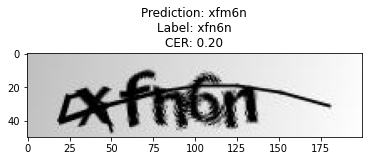

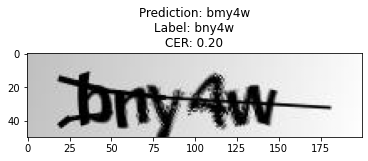

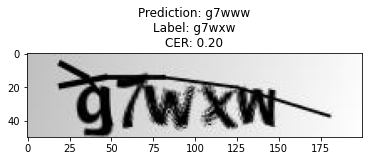

In [16]:
val_cer = evaluate(model, val_loader, encoder, k=10)

In [17]:
print(f'Training CER = {train_cer:.3f}\nValidation CER = {val_cer:.3f}')

Training CER = 0.000
Validation CER = 0.024


As we can see from worst examples in VAL dataset, typical errors are:
* n &harr; m
* e &harr; c
* 3 &harr; 5
* w &harr; x

Augmentations and lr scheduling should help to reduce CER futher.